In [1]:
import warnings   
warnings.simplefilter("ignore") 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib notebook
import sys
sys.path.append('/Users/Serene/calour')
import calour as cl
import numpy as np
import pandas as pd
import calour.cahelper as cah
import calour.analysis

from scipy.stats import sem

In [26]:
cl.set_log_level(40) # get rid of warnings in calour

In [4]:
dme = cl.read_taxa('data/dme.biom','data/dme.map.txt', sparse=False, filter_orig_reads=1000)

In [5]:
dme.sample_metadata.misc_param.value_counts()

unknown              35
cesarean delivery    27
vaginal delivery     17
Name: misc_param, dtype: int64

In [6]:
np.random.seed(31)
dme_sub1 = dme.filter_min_abundance(5)

## check p-values

In [8]:
def ds_gap(pvals, cdf):
    gap = []
    for i in range(len(pvals)):
        dist = pvals[i] - cdf[i]
        if dist > 0:
            gap.append(dist)
        if dist <= 0:
            gap.append(0)
    norm = np.sum(gap)
    return norm

In [11]:
xx = dme_sub1.diff_abundance('misc_param','cesarean delivery','vaginal delivery', alpha = 1, fdr_method='dsfdr')

In [12]:
yy = xx.feature_metadata['_calour_diff_abundance_pval']

<IPython.core.display.Javascript object>


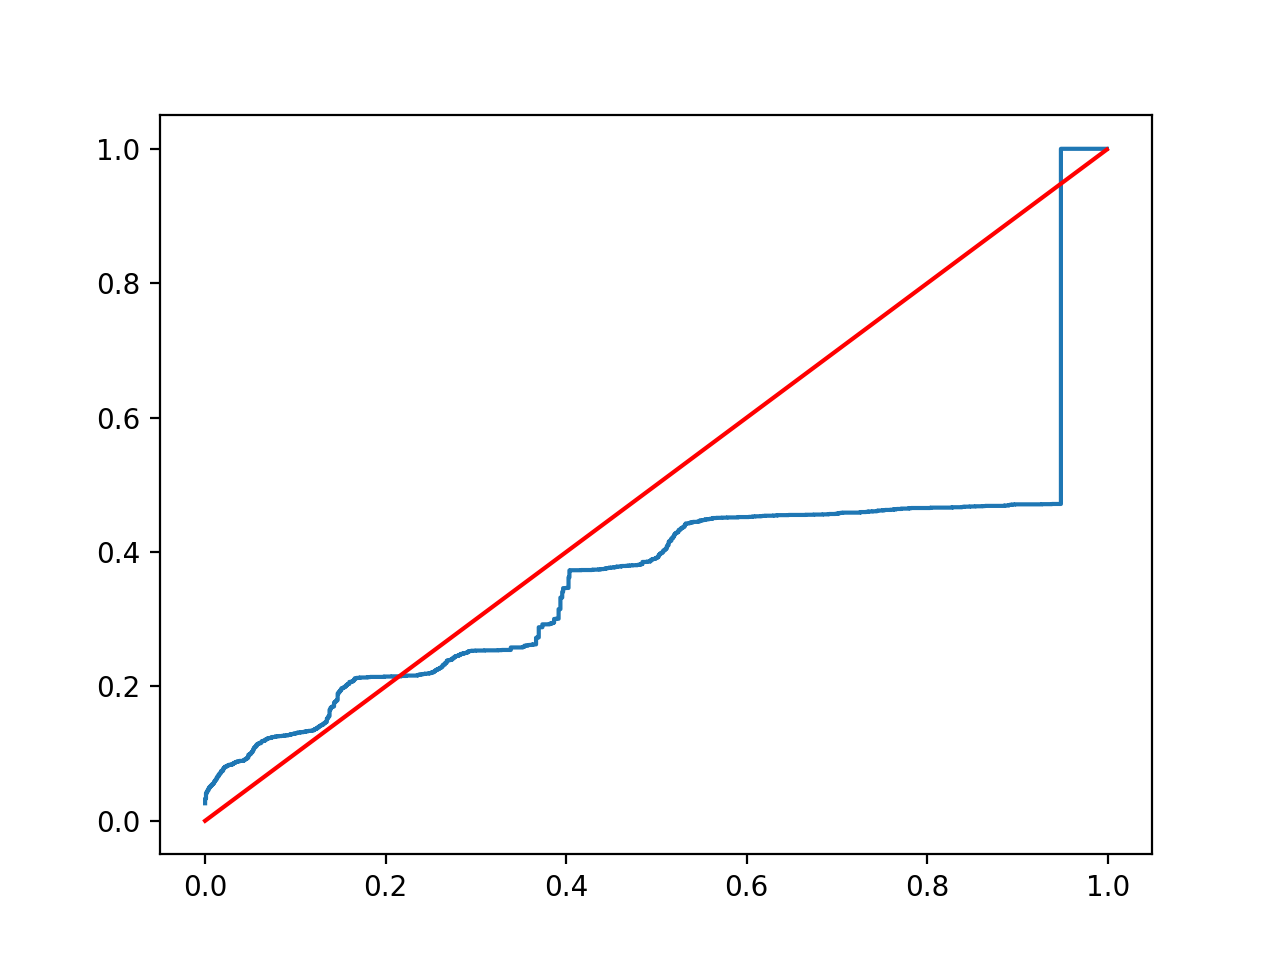

80.9536805986


In [13]:
from statsmodels.distributions.empirical_distribution import ECDF
from numpy import linalg as LA

sample = yy  
ecdf = ECDF(sample)

x = np.sort(sample)
y = ecdf(x)
plt.figure()
plt.step(x, y)
plt.plot(x, x, color = 'red')

gap = []
for i in range(len(x)):
    dist = x[i] - y[i]
    if dist > 0:
        gap.append(dist)
    if dist <= 0:
        gap.append(0)
norm = np.sum(gap)
print(norm)

## subsamples

In [51]:
np.random.seed(31)

B = 100
ss = np.arange(5,20,5)

otu_bh = []
otu_fbh = []
otu_ds = []

err_bh = []
err_fbh = []
err_ds = []

for i in ss:
    print('subsample...: %s' %(i))
    
    ds_num = []
    bh_num = []
    fbh_num = []
    for j in range(B):
        dme_sub2 = dme_sub1.downsample('misc_param', num_keep=i)
        ds = dme_sub2.diff_abundance('misc_param','cesarean delivery','vaginal delivery',fdr_method='dsfdr')
        bh = dme_sub2.diff_abundance('misc_param','cesarean delivery','vaginal delivery',fdr_method='bhfdr')
        fbh = dme_sub2.diff_abundance('misc_param','cesarean delivery','vaginal delivery',fdr_method='filterBH')

        if ds is None:
            sig_ds = 0
        else:
            sig_ds = len(ds.feature_metadata.index)
        if bh is None:
            sig_bh = 0
        else:
            sig_bh = len(bh.feature_metadata.index)
        if fbh is None:
            sig_fbh = 0
        else:
            sig_fbh = len(fbh.feature_metadata.index)

        ds_num.append(sig_ds)
        bh_num.append(sig_bh)
        fbh_num.append(sig_fbh)
    
    otu_ds.append(np.mean(ds_num))
    otu_bh.append(np.mean(bh_num))
    otu_fbh.append(np.mean(fbh_num))
    
    err_ds.append(sem(ds_num))  
    err_bh.append(sem(bh_num))
    err_fbh.append(sem(fbh_num))

subsample...: 5
subsample...: 10
subsample...: 15


In [52]:
print(otu_ds)

[47.170000000000002, 140.36000000000001, 265.88999999999999]


<IPython.core.display.Javascript object>


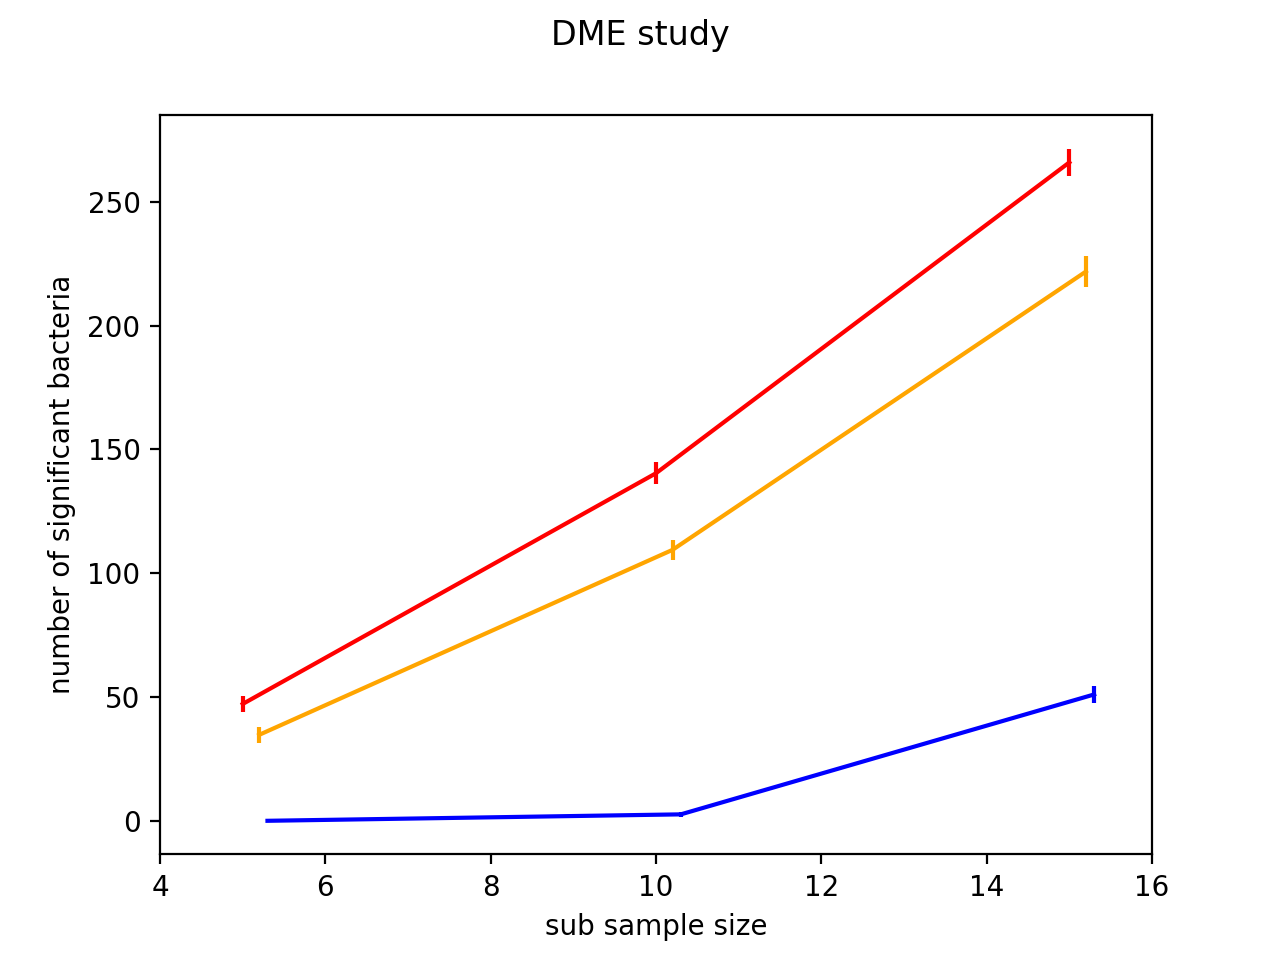

(4, 16)

In [59]:
plt.figure()
plt.errorbar(ss, otu_ds, yerr=err_ds, color = 'red')
plt.errorbar(ss+0.2, otu_fbh, yerr=err_fbh, color = 'orange')
plt.errorbar(ss+0.3, otu_bh, yerr=err_bh, color = 'blue')
plt.suptitle('DME study')
plt.xlabel('sub sample size')
plt.ylabel('number of significant bacteria')

pylab.xlim([4, 16])

In [60]:
import pickle
with open("dme_subsample.pkl", "wb") as f:
    pickle.dump((ss, otu_ds, otu_bh, otu_fbh, err_ds, err_bh, err_fbh), f)

In [ ]:
import pickle
with open("dme_subsample.pkl", "rb") as f:
    ss, otu_ds, otu_bh, otu_fbh, err_ds, err_bh, err_fbh = pickle.load(f)